## `Bank Customer Churn` Prediction using ML Algorithms

In this project, we will be using the `Bank Customer Churn` Prediction dataset from [Kaggle](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset) to predict whether a customer will leave the bank or not. We will be using various machine learning algorithms to predict the outcome and compare the results.

In [51]:
# necessary imports
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
import xgboost as xgb

import git

import warnings
warnings.filterwarnings('ignore')

In [52]:
sns.set_style("darkgrid")
sns.set_palette("colorblind")

### 1. Exploratory Data Analysis (EDA)

In [53]:
repoPath = git.Repo('.', search_parent_directories=True).working_tree_dir
dataPath = repoPath + "/data/Bank_Customer_Churn_Prediction.csv"

In [54]:
df = pd.read_csv(dataPath)
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [55]:
# check for missing values
#df.isnull().sum() # no missing values

# check for duplicates
#df.duplicated().sum() # no duplicates

#### Let's do a couple of plots 

estimated_salary vs churn

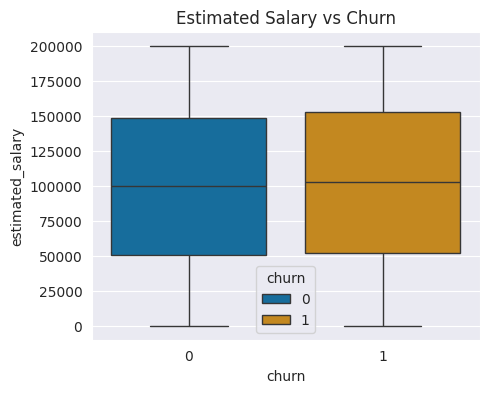

In [56]:
# estimated_salary vs churn
fig = plt.figure(figsize=(5, 4))
sns.boxplot(x='churn', y='estimated_salary', data=df, hue='churn')
plt.title('Estimated Salary vs Churn')
plt.show()

How does country affect the churn rate?

<Figure size 1000x500 with 0 Axes>

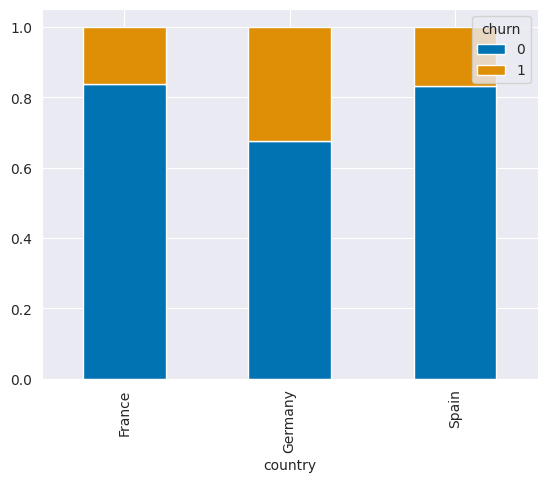

In [57]:
# how does country affect churn rate
# plot percentage of total customers for each country 
fig = plt.figure(figsize=(10, 5))
country_churn = df.groupby('country')['churn'].value_counts(normalize=True).unstack()
country_churn.plot(kind='bar', stacked='True');

Do more EDA and add more plots to understand the data better...

### 2. Encoding Categorical Variables and Correlation

In [58]:
# get rid of the `customer_id` column if it exists
if 'customer_id' in df.columns:
    df.drop('customer_id', axis=1, inplace=True)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [59]:
# encode categorical variables
def encode_categorical(df):
    # find categorical columns
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # encode categorical columns
    for col in categorical_columns:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes
    return df

In [60]:
df = encode_categorical(df)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [61]:
# `Pearson` correlation coefficient: How features are related to the target variable `churn`
correlation = df.corr()['churn'].sort_values(ascending=False)
correlation

churn               1.000000
age                 0.285323
balance             0.118533
country             0.035943
estimated_salary    0.012097
credit_card        -0.007138
tenure             -0.014001
credit_score       -0.027094
products_number    -0.047820
gender             -0.106512
active_member      -0.156128
Name: churn, dtype: float64

Not all features are strongly correlated with the target variable. Therefore, they don't have much predictive power. So, we will select only the features that are strongly correlated with the target variable, and have a `correlation coefficient of more than 0.1`.

In [62]:
# select features with `abs` correlation greater than 0.1
features = correlation[abs(correlation) > 0.1].index    
print(features)

df_selected = df[features]
df_selected.head()

Index(['churn', 'age', 'balance', 'gender', 'active_member'], dtype='object')


,churn,age,balance,gender,active_member
0,1,42,0.00,0,1
1,0,41,83807.86,0,1
2,1,42,159660.80,0,0
3,0,39,0.00,0,0
4,0,43,125510.82,0,1


In [63]:
df_selected.corr()['churn'].sort_values(ascending=False)

churn            1.000000
age              0.285323
balance          0.118533
gender          -0.106512
active_member   -0.156128
Name: churn, dtype: float64

### 3. Splitting the Data into Training and Testing Sets 

We will split the data into training and testing sets for model training and evaluation. However, before that, we will check the class distribution to ensure that the data is not `imbalanced`.

#### 3.1 Check of class imbalance

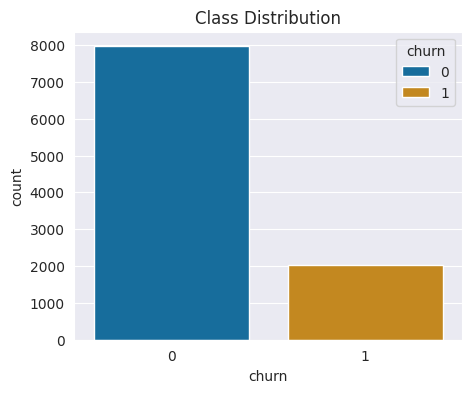

In [64]:
# Check for class imbalance
fig = plt.figure(figsize=(5, 4))
sns.countplot(x = 'churn', data=df_selected, hue='churn')
plt.title('Class Distribution')
plt.show()

The dataset is highly `imbalanced`, with the majority class having a significantly higher number of instances compared to the minority class. We will use the `SMOTETomek` technique to balance the dataset.

#### 3.2 SMOTETomek and Normal Split

We will use the `SMOTE` and `Tomek` links technique to balance the dataset. The `SMOTE` technique generates synthetic samples for the minority class, while the `Tomek` links technique removes the samples that are close to the decision boundary.

In [65]:
X = df_selected.drop('churn', axis=1)
y = df_selected['churn']

# SMOTE and Tomek Links
smk = SMOTETomek(random_state=42)
X_res_smk, y_res_smk = smk.fit_resample(X, y)
X_train_smk, X_test_smk, y_train_smk, y_test_smk = train_test_split(X_res_smk, y_res_smk, test_size=0.2, random_state=42)

# Normal split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Model Building and Evaluation

We will use `XGBoost` classifier to build the model and evaluate its performance. 

In [67]:
# make a classifier function to train and test the model
def xgb_classifier(X_train, X_test, y_train, y_test, print_results=True, params:dict={}):
    """
    This function trains and tests the XGBoost classifier
    """
    # create the classifier
    clf = xgb.XGBClassifier(**params)

    # train the classifier
    clf.fit(X_train, y_train)

    # predict the values
    y_pred = clf.predict(X_test)

    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    classification_report = sklearn.metrics.classification_report(y_test, y_pred)

    print("====================================================================")
    print("Accuracy: ", accuracy)
    print("====================================================================")
    print("Classification report: \n", classification_report)
    print("====================================================================")

    return accuracy, classification_report


#### 4.1 With Normal Split

In [68]:
_, _ = xgb_classifier(X_train, X_test, y_train, y_test)

Accuracy:  0.826
Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      1607
           1       0.61      0.31      0.41       393

    accuracy                           0.83      2000
   macro avg       0.73      0.63      0.66      2000
weighted avg       0.80      0.83      0.80      2000



As the dataset is highly imbalanced, we get a very poor precision, recal and f1-score for the minority class using the normal split.

To address this issue, we will use the `SMOTETomek` split to balance the dataset and test the model performance.

#### 4.2 With SMOTETomek Split

In [69]:
_, _ = xgb_classifier(X_train_smk, X_test_smk, y_train_smk, y_test_smk)

Accuracy:  0.7926267281105991
Classification report: 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      1425
           1       0.79      0.80      0.79      1396

    accuracy                           0.79      2821
   macro avg       0.79      0.79      0.79      2821
weighted avg       0.79      0.79      0.79      2821



Boom! We get a significant improvement in the precision, recall, and f1-score for the minority class using the `SMOTETomek` split.

### 5. Hyperparameter Tuning

We will use `Optuna` to tune the hyperparameters of the XGBoost classifier.

In [71]:
# define the objective function
def objective(trial):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # define the parameters
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),

        'objective': 'binary:logistic',
        'n_jobs': -1,
        'tree_method': 'gpu_hist' if device == 'cuda' else 'auto',
        'random_state': 42
    }

    # create the classifier
    clf = xgb.XGBClassifier(**param)    

    # train the classifier
    clf.fit(X_train_smk, y_train_smk)

    # predict the values
    y_pred = clf.predict(X_test_smk)

    accuracy = sklearn.metrics.accuracy_score(y_test_smk, y_pred)

    return accuracy

In [72]:
# create the study
study = optuna.create_study(direction='maximize')   
study.optimize(objective, n_trials=5)

[I 2024-04-01 13:35:53,455] A new study created in memory with name: no-name-3881d7a3-4122-44e5-a1d2-b9cddf850725
[I 2024-04-01 13:35:53,592] Trial 0 finished with value: 0.7919177596596951 and parameters: {'max_depth': 6, 'n_estimators': 400, 'learning_rate': 0.2633002931485752, 'subsample': 0.8450764557710937, 'min_child_weight': 10}. Best is trial 0 with value: 0.7919177596596951.
[I 2024-04-01 13:35:53,670] Trial 1 finished with value: 0.7908543069833393 and parameters: {'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.06168964327123356, 'subsample': 0.7002982431389089, 'min_child_weight': 8}. Best is trial 0 with value: 0.7919177596596951.
[I 2024-04-01 13:35:53,800] Trial 2 finished with value: 0.7908543069833393 and parameters: {'max_depth': 8, 'n_estimators': 300, 'learning_rate': 0.015716677403226447, 'subsample': 0.22553817429457546, 'min_child_weight': 9}. Best is trial 0 with value: 0.7919177596596951.
[I 2024-04-01 13:35:53,828] Trial 3 finished with value: 0.788372

In [73]:
# get the best parameters
best_params = study.best_params

# train the model with the best parameters
_, _ = xgb_classifier(X_train_smk, X_test_smk, y_train_smk, y_test_smk, params=best_params)

Accuracy:  0.7862460120524637
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      1425
           1       0.78      0.79      0.78      1396

    accuracy                           0.79      2821
   macro avg       0.79      0.79      0.79      2821
weighted avg       0.79      0.79      0.79      2821



### 6. Conclusion

In this project, we used the `Bank Customer Churn` Prediction dataset to predict whether a customer will leave the bank or not. We used `XGBoost` classifier to build the model and evaluated its performance. We also used the `SMOTETomek` technique to balance the dataset and improve the model performance. Finally, we used `Optuna` to tune the hyperparameters of the XGBoost classifier and further improve the model performance.